In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import time

# Libs
import torch
from rembg import remove, new_session
from ultralytics import YOLO
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2

from process.get_features import compute_depth, compute_pose_and_mask

RESULTS_FOLDER = "results/"

Using cache found in C:\Users\Giacomo/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\Giacomo\anaconda3\envs\mov_viz\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in C:\Users\Giacomo/.cache\torch\hub\intel-isl_MiDaS_master


# Test videos

In [2]:
TEST_VIDEO_FOLDER = "data/clips_algoTest/"
videos = os.listdir(TEST_VIDEO_FOLDER)
videos[:3]

['edition10_sequence_0_closeup.mp4',
 'edition10_sequence_0_distant.mp4',
 'edition14_sequence_0_closeup.mp4']

In [3]:
def get_frame(video_path, frame_num):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    cap.release()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

In [4]:
TEST_IMAGES_FOLDER = "data/test_images/"

test_images = os.listdir(TEST_IMAGES_FOLDER)

if len(test_images) == 0:
    # Save sample of frames from each video
    for video in videos:
        video_path = TEST_VIDEO_FOLDER + video
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        frame_nums = np.linspace(0, frame_count-1, 10, dtype=int)
        for frame_num in frame_nums:
            frame = get_frame(video_path, frame_num)
            plt.imsave(TEST_IMAGES_FOLDER + video + "_" + str(frame_num) + ".jpg", frame)
        
    test_images = os.listdir(TEST_IMAGES_FOLDER)

# Test libs

## Pose estimation

### YOLOv8

In [7]:
# Load the YOLOv8 model
model = YOLO('yolov8n-pose.pt')

# Open the video file
video_path = os.path.join(TEST_VIDEO_FOLDER, videos[0])
cap = cv2.VideoCapture(video_path)

pose_results = []
# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLOv8 inference on the frame
        results = model(frame)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Display the annotated frame
        cv2.imshow("YOLOv8 Inference", annotated_frame)
        pose_results.append(results[0])
        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()


0: 544x640 1 person, 14.0ms
Speed: 2.0ms preprocess, 14.0ms inference, 5.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 6.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 6.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 10.5ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 8.0ms
Speed: 5.0ms preprocess, 8.0ms inference, 10.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 7.0ms
Speed: 8.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

0: 544x640 1 person, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)


In [21]:
pose_results[0].keypoints.xyn.cpu().numpy()[0]

array([[    0.50121,     0.29579],
       [    0.51106,     0.29129],
       [    0.49338,     0.28531],
       [    0.52108,     0.30927],
       [    0.47651,     0.29755],
       [    0.54245,     0.37225],
       [    0.44635,      0.3646],
       [    0.57291,     0.40098],
       [    0.39632,     0.41392],
       [    0.61021,     0.44175],
       [    0.32335,     0.43089],
       [    0.51598,     0.51714],
       [    0.45558,     0.50088],
       [    0.48603,      0.6534],
       [    0.40693,     0.57913],
       [    0.50253,     0.79423],
       [    0.44027,     0.67821]], dtype=float32)

In [23]:
pose_results[0].keypoints.conf.cpu().numpy()[0]

array([    0.98827,     0.95705,     0.95932,     0.82176,     0.83328,     0.99807,     0.99864,      0.9888,     0.99076,     0.97152,     0.97491,      0.9994,     0.99944,      0.9981,     0.99811,     0.98776,     0.98916], dtype=float32)

### Mediapipe

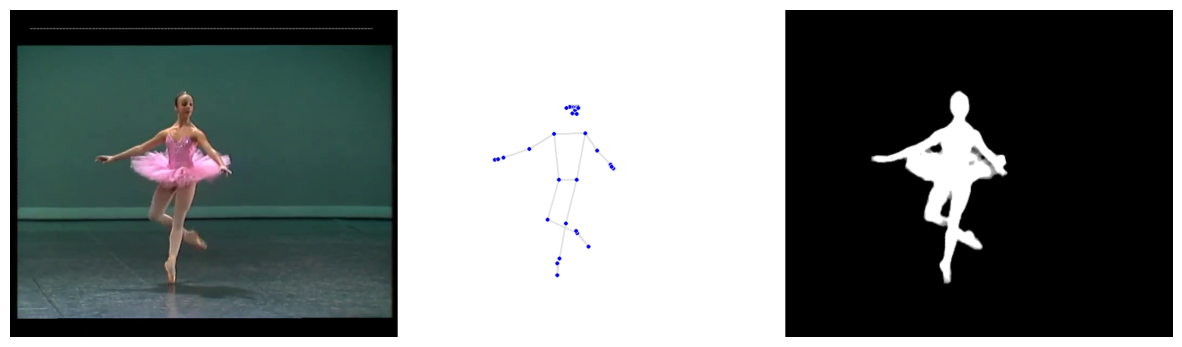

In [40]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(enable_segmentation = True)

frame = get_frame(video_path, 60)
result = pose.process(frame)

# Draw the pose landmarks on white background
pose_img = np.ones_like(frame) * 255
if result.pose_landmarks:
    mp_drawing.draw_landmarks(pose_img, result.pose_landmarks, mp_pose.POSE_CONNECTIONS)

# Draw segmentation mask on the frame
segmentation_mask = result.segmentation_mask
visualized_mask = np.repeat(segmentation_mask[:, :, np.newaxis], 3, axis=2) * 255
visualized_mask = visualized_mask.astype(np.uint8)

# Stich the frame and the mask together
output = np.concatenate((frame, pose_img, visualized_mask), axis=1)

# Display the output
plt.figure(figsize=(15, 15))
plt.imshow(output)
plt.axis("off")
plt.show()

## Depth maps

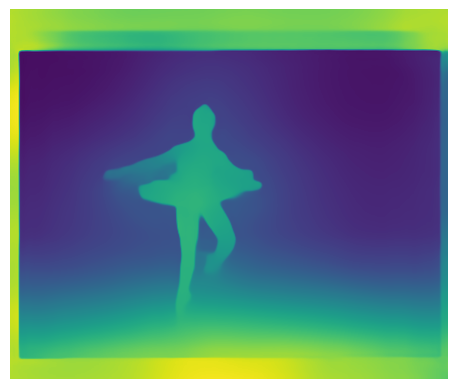

In [73]:
video_path = os.path.join(TEST_VIDEO_FOLDER, videos[0])
img = get_frame(video_path, frame_num=25)

output = compute_depth(img)

plt.imshow(output)
plt.axis("off")
plt.show()

## Remove bg

In [ ]:
video_path = os.path.join(TEST_VIDEO_FOLDER, videos[0])
img = get_frame(video_path, frame_num=25)

output = remove(img)
plt.imshow(output)
plt.show()

In [28]:
# Open the video file
video_path = os.path.join(TEST_VIDEO_FOLDER, videos[0])
cap = cv2.VideoCapture(video_path)

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        output = remove(frame)

        # Display the annotated frame
        output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        cv2.imshow("Remove bg", output)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()

# Process video

In [59]:
def process_video(video, bg_session):
    time_start = time.time()
    
    # Open the video file
    video_path = os.path.join(TEST_VIDEO_FOLDER, video)
    cap = cv2.VideoCapture(video_path)

    results_folder = RESULTS_FOLDER + video.split(".")[0] + "/"
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)

    depth_folder = results_folder + "depth/"
    if not os.path.exists(depth_folder):
        os.makedirs(depth_folder)

    bg_folder = results_folder + "bg/"
    if not os.path.exists(bg_folder):
        os.makedirs(bg_folder)

    # Loop through the video frames
    while cap.isOpened():
        # Read a frame from the video
        success, frame = cap.read()

        if success:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            n_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))

            # Depth
            output_depth = compute_depth(frame)
            fp_depth = depth_folder + str(n_frame) + "_depth.png"
            cv2.imwrite(fp_depth, output_depth)

            # Background
            output_bg = remove(frame, session=bg_session)
            output_bg = cv2.cvtColor(output_bg, cv2.COLOR_BGR2RGB)
            fp_bg = bg_folder + str(n_frame) + "_bg.png"
            cv2.imwrite(fp_bg, output_bg)
        else:
            # Break the loop if the end of the video is reached
            break

    # Release the video capture object and close the display window
    cap.release()

    time_end = time.time()
    print(f"Processed {n_frame} frames in {time_end - time_start} seconds for video {video}")

    return (n_frame, time_end - time_start)

In [60]:
bg_session = new_session()

time_stats = []
for video in videos:
    stats = process_video(video, bg_session=bg_session)
    time_stats.append(stats)

Processed 477 frames in 102.05228734016418 seconds for video edition10_sequence_0_closeup.mp4
Processed 241 frames in 51.87295913696289 seconds for video edition10_sequence_0_distant.mp4
Processed 353 frames in 75.34694600105286 seconds for video edition14_sequence_0_closeup.mp4
Processed 453 frames in 96.50540018081665 seconds for video edition19_sequence_9_distantToCloseup.mp4
Processed 160 frames in 34.372655153274536 seconds for video edition23_sequence_0_behind.mp4
Processed 407 frames in 87.04902052879333 seconds for video edition23_sequence_0_closeup.mp4
Processed 242 frames in 55.56810688972473 seconds for video edition23_sequence_0_distant.mp4
Processed 619 frames in 144.76258730888367 seconds for video edition27_sequence_1_closeup.mp4
Processed 521 frames in 142.27536296844482 seconds for video edition31_sequence_0_closeup.mp4
Processed 487 frames in 131.99452900886536 seconds for video edition36_sequence_3_closeup.mp4
Processed 566 frames in 154.07143831253052 seconds for vi

In [64]:
np.mean([t / n for n, t in time_stats])

0.2436092009950486

In [7]:
def show_video_results(video):
    cap = cv2.VideoCapture(video_path)

    keypoints = []
    count = 0

    # Loop through the video frames
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pose_keypoints, pose_bg, mask = compute_pose_and_mask(frame_rgb)
        pose_keypoints = [count] + pose_keypoints
        keypoints.append(pose_keypoints)
        
        # Process mask
        if mask is not None:
            visualized_mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2) * 255
            visualized_mask = visualized_mask.astype(np.uint8)
        else:
            visualized_mask = np.zeros_like(img)

        # Depth
        depth = compute_depth(frame)
        depth_img = np.repeat(depth[:, :, np.newaxis], 3, axis=2)
        depth_img = (depth_img / depth_img.max()) * 255
        depth_img = depth_img.astype(np.uint8)

        # Stich the frame and the results together
        output1 = np.concatenate((frame, pose_bg), axis=1)
        output2 = np.concatenate((visualized_mask, depth_img), axis=1)
        output = np.concatenate((output1, output2), axis=0)

        # Display the frame
        cv2.imshow('MediaPipe results', output)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

        count += 1

    cap.release()
    cv2.destroyAllWindows()

    return keypoints

In [10]:
video_path = os.path.join(TEST_VIDEO_FOLDER, videos[0])
keypoints = show_video_results(video_path)

In [8]:
from process.process_features import joints

data = pd.DataFrame(keypoints, columns = ["frame_index"] + joints)
for joint in joints:
    data[joint] = data[joint].map(lambda x: ",".join([str(w) for w in x]))

data.head()

,frame_index,NOSE,LEFT_EYE_INNER,LEFT_EYE,LEFT_EYE_OUTER,RIGHT_EYE_INNER,RIGHT_EYE,RIGHT_EYE_OUTER,LEFT_EAR,RIGHT_EAR,...,LEFT_HIP,RIGHT_HIP,LEFT_KNEE,RIGHT_KNEE,LEFT_ANKLE,RIGHT_ANKLE,LEFT_HEEL,RIGHT_HEEL,LEFT_FOOT_INDEX,RIGHT_FOOT_INDEX
0,0,"0.45665502548217773,0.32297876477241516,-0.162...","0.46297457814216614,0.3152253031730652,-0.1380...","0.46655189990997314,0.31589043140411377,-0.138...","0.47012603282928467,0.3168078064918518,-0.1381...","0.4543294608592987,0.31469306349754333,-0.1362...","0.45189911127090454,0.3149416446685791,-0.1362...","0.44956886768341064,0.31512102484703064,-0.136...","0.48013967275619507,0.32502079010009766,-0.027...","0.45257318019866943,0.32186025381088257,-0.018...",...,"0.4861390292644501,0.5409367084503174,0.023138...","0.44271114468574524,0.545958936214447,-0.02294...","0.5592638850212097,0.5970097780227661,-0.13969...","0.4391125440597534,0.6682939529418945,-0.09358...","0.4789864122867584,0.6454519033432007,0.046538...","0.44484540820121765,0.7961995005607605,0.01570...","0.4598359763622284,0.6415532231330872,0.062757...","0.45284271240234375,0.8078088760375977,0.02024...","0.46974173188209534,0.7032223343849182,-0.0126...","0.4365547299385071,0.8492331504821777,-0.10726..."
1,1,"0.45702382922172546,0.32182443141937256,-0.198...","0.46414434909820557,0.31429803371429443,-0.175...","0.46744418144226074,0.31502753496170044,-0.175...","0.4708080291748047,0.3159034252166748,-0.17535...","0.45564544200897217,0.3133557140827179,-0.1727...","0.45305877923965454,0.3134945333003998,-0.1727...","0.45056021213531494,0.31351330876350403,-0.172...","0.48009833693504333,0.3245853781700134,-0.0622...","0.4526410698890686,0.31977105140686035,-0.0482...",...,"0.485077440738678,0.5320751070976257,0.0221145...","0.43971240520477295,0.5380964875221252,-0.0218...","0.5586923956871033,0.5985121130943298,-0.09957...","0.4385890066623688,0.6676719188690186,-0.10762...","0.4819270968437195,0.6460692882537842,0.126958...","0.44503000378608704,0.7955140471458435,0.01812...","0.4668271839618683,0.6427505612373352,0.145678...","0.45274582505226135,0.8076796531677246,0.02395...","0.46510687470436096,0.6888551712036133,0.06378...","0.43752941489219666,0.8451836109161377,-0.1072..."
2,2,"0.4573805034160614,0.32182952761650085,-0.1873...","0.4648008644580841,0.31425943970680237,-0.1653...","0.46813148260116577,0.31500253081321716,-0.165...","0.47155851125717163,0.3158852458000183,-0.1654...","0.45568346977233887,0.3132392168045044,-0.1566...","0.45304709672927856,0.3133494555950165,-0.1566...","0.4504747986793518,0.3133302927017212,-0.15651...","0.4800829291343689,0.3243977725505829,-0.05126...","0.4515358805656433,0.31852781772613525,-0.0173...",...,"0.4850551187992096,0.5327025055885315,0.013331...","0.43808668851852417,0.5387131571769714,-0.0130...","0.5557360053062439,0.6048588752746582,-0.10863...","0.4389248788356781,0.6787384152412415,-0.09944...","0.4882318675518036,0.6628887057304382,0.139773...","0.4461813271045685,0.7965280413627625,0.074572...","0.47168561816215515,0.6659252047538757,0.16135...","0.4530424475669861,0.808589518070221,0.0842983...","0.4651649594306946,0.7046783566474915,0.071607...","0.4412831664085388,0.8425436615943909,-0.04737..."
3,3,"0.4582575559616089,0.32173943519592285,-0.1615...","0.4659267067909241,0.3140134811401367,-0.13729...","0.46943265199661255,0.31476619839668274,-0.137...","0.47298169136047363,0.31565701961517334,-0.137...","0.45607054233551025,0.3129626512527466,-0.1312...","0.45316386222839355,0.3130570948123932,-0.1312...","0.45047104358673096,0.31303802132606506,-0.131...","0.48039573431015015,0.32400694489479065,-0.019...","0.45116525888442993,0.3173951506614685,0.00735...",...,"0.48505884408950806,0.5305096507072449,0.00606...","0.4383189380168915,0.535908043384552,-0.005698...","0.5447607040405273,0.6161144375801086,-0.12372...","0.4412018358707428,0.6779607534408569,-0.09917...","0.48726606369018555,0.6915386319160461,0.06891...","0.4476274847984314,0.798022806644439